# 19. QLS - The Dangers of Overfitting

In [29]:
import numpy as np
import pandas as pd
from scipy import poly1d
import seaborn as sb
sb.set(rc={'figure.figsize':(11.7,8.27)})
sb.set_style("whitegrid", {"grid.color":".6", "grid.linestyle":":"})
import statsmodels.api as sm
from statsmodels import regression
import yfinance as yf

## What is Overfitting?

When building a model the parameters, and itself, are fit to sampled data. Then, the model is used to predict data that hasn't been observed. A model is overfit when it's sensitive to noise and events in the sample data, which does not reflect the underlying process.

The key to understanding this is in the noise present. Consider a set of data as $D_{T}$, the true underlying data from whatever process is being modeled, and some random noise as $\epsilon$. Since what is being observed is $D = D_{T} + \epsilon$, the model might fit to $\epsilon$ instead of $D_{T}$.

This is an issue since a model must only fit to the sample data so long as it gives an accurate fit for future data. The two main causes of overfitting are:

- small sample size, meaning noise and trend aren't distinguishable.
- high model complexity, meaning the model ends up contorting to fit the noise.

### Example: Too Many Rules (Complexity)

Evaluate the following dataset:

| TV Channel | Room Lighting Intensity | Enjoyment |
|:----------:|:-----------------------:|:---------:|
|     1      |            2            |     1     |
|     2      |            3            |     2     |
|     3      |            1            |     3     |

To try and predict enjoyment, the following rules are created:

1. If TV Channel is 1, and lighting intensity is 2, then enjoyment will be 1.
2. If TV Channel is 2, and lighting intensity is 3, then enjoyment will be 2.
3. If TV Channel is 3, and lighting intensity is 1, then enjoyment will be 3
4. In all other cases, predict an average enjoyment of 2.

This is a well-defined model for future data, but imagine that the enjoyment is independent of the lighting. Because there is a rule for each row, the model is perfectly predictive of historical data, but is likely to perform poorly in trials.

Generalizing this to stocks, if the model is developed with specific rules based on **specific past events**, it's most likely overfitting. This is why black-box machine learning (neural networks, data-mining, etc.) is so dangerous if not done correctly.

### Example: Curve Fitting

This is easily seen with polynomial regression. A dataset is constructed below which noisily follows a quadratic. The linear model is underfit: since the data is nonlinear. The quadratic curve has some error but fits well.

When a ninth-degree polynomial is fit to the data, the error is zero - a ninth-degree polynomial can be build to go through any 10 points - but, looking at the tails of the curve, it can't be expected to predict other samples. It fits the data **perfectly**, because it fits the noise. In this case, it's a model that's too complex.

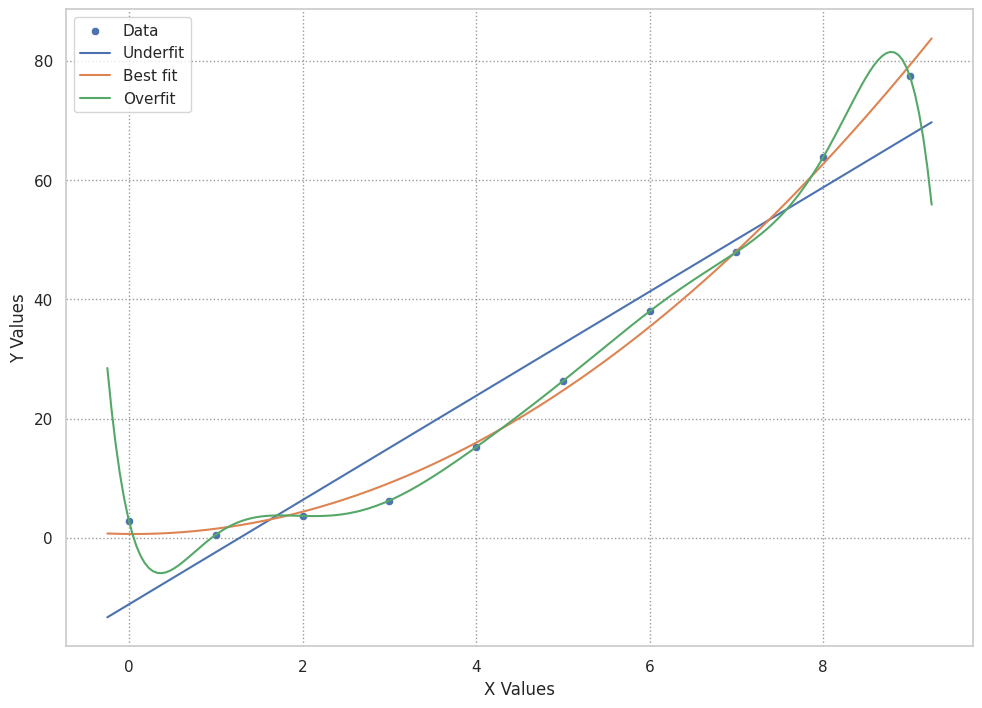

In [30]:
x = np.arange(10)
y = 2*np.random.randn(10) + x**2
xs = np.linspace(-0.25, 9.25, 200)

lin = np.polyfit(x, y, 1)
quad = np.polyfit(x, y, 2)
many = np.polyfit(x, y, 9)

sb.scatterplot(x=x, y=y, label="Data")
sb.lineplot(x=xs, y=poly1d(lin)(xs), label="Underfit")
sb.lineplot(x=xs, y=poly1d(quad)(xs), label="Best fit")
sb.lineplot(x=xs, y=poly1d(many)(xs), label="Overfit").set(xlabel="X Values", ylabel="Y Values");

When working with real data, it's unlikely that a ninth-degree polynomial is appropriate: the function should reflect a belief about the underlying process.

### Example: Regression Parameters

Which variables should be included in a model? Omitting one that's important might be bad, so including all the ones that improve the fit might seem sensible. Below, one asset is regressed against an asset from the same sector, and three other unrelated ones.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SLR R-squared: 0.7759427641373828
SLR p-value: 2.1628937873668626e-83
MLR R-squared: 0.8401380424467539
MLR p-value: 6.643209344272803e-98


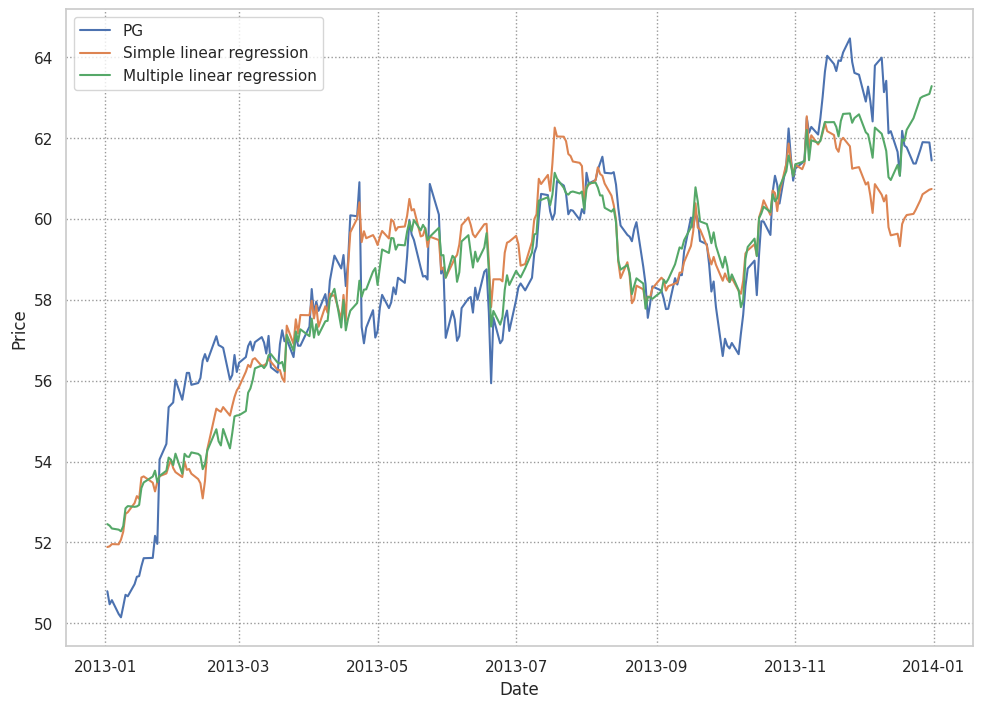

In [31]:
# load one year's worth of pricing data for five different assets
start = "2013-01-01"
end = "2014-01-01"

x1 = yf.download("PEP", start, end)
x1 = x1["Adj Close"]
x2 = yf.download("MCD", start, end)
x2 = x2["Adj Close"]
x3 = yf.download("AAPL", start, end)
x3 = x3["Adj Close"]
x4 = yf.download("^DJI", start, end)
x4 = x4["Adj Close"]
y = yf.download("PG", start, end)
y = y["Adj Close"]

# build a linear model using only x1 to explain y
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*x1

# run multiple linear regression using x1, x2, x3, x4 to explain y
mlr = regression.linear_model.OLS(y, sm.add_constant(np.column_stack((x1,x2,x3,x4)))).fit()
mlr_prediction = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# compute adjusted R-squared for the two different models
print("SLR R-squared:", slr.rsquared_adj)
print("SLR p-value:", slr.f_pvalue)
print("MLR R-squared:", mlr.rsquared_adj)
print("MLR p-value:", mlr.f_pvalue)

# plot y and the two different predictions
sb.lineplot(y, label="PG")
sb.lineplot(slr_prediction, label="Simple linear regression")
sb.lineplot(mlr_prediction, label="Multiple linear regression").set(xlabel="Date", ylabel="Price");

However, when using the same parameters for a different time period, it can be seen that the simple model fits worse and the multiple-variable model is useless. The relationships found were particular to the previous time period.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SLR R-squared: 0.7897354515748035
SLR p-value: 7.623460030832868e-87
MLR R-squared: 0.8506624615407425
MLR p-value: 1.4961656599089682e-101


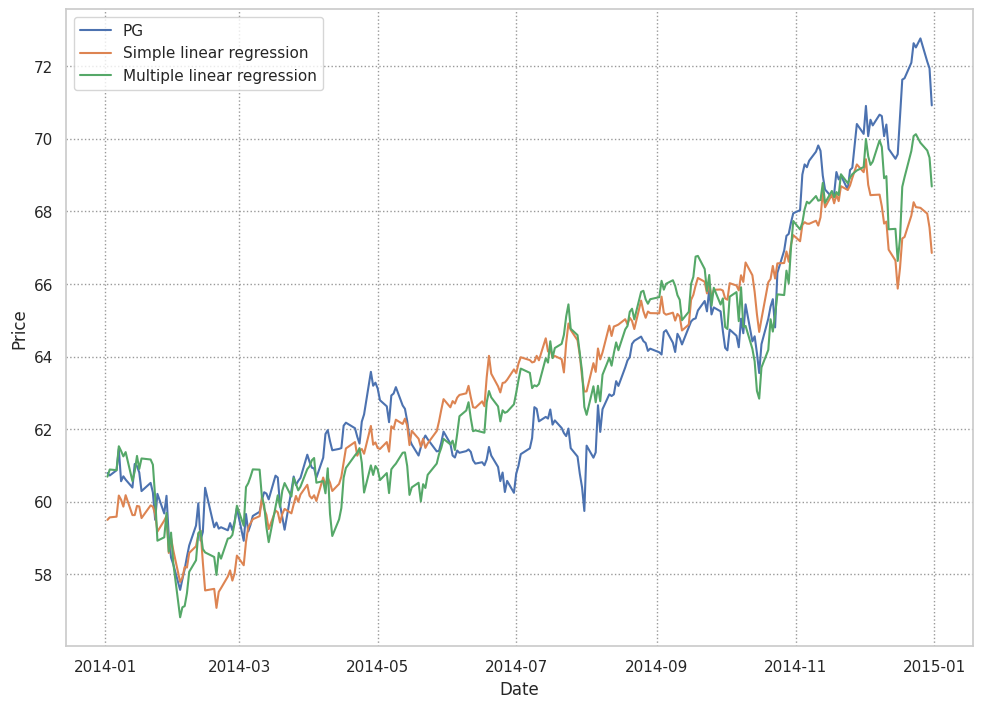

In [32]:
start = "2014-01-01"
end = "2015-01-01"

x1 = yf.download("PEP", start, end)
x1 = x1["Adj Close"]
x2 = yf.download("MCD", start, end)
x2 = x2["Adj Close"]
x3 = yf.download("AAPL", start, end)
x3 = x3["Adj Close"]
x4 = yf.download("^DJI", start, end)
x4 = x4["Adj Close"]
y = yf.download("PG", start, end)
y = y["Adj Close"]

# extend the model to the new time period
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*x1
mlr = regression.linear_model.OLS(y, sm.add_constant(np.column_stack((x1,x2,x3,x4)))).fit()
mlr_prediction = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# compute adjusted R-squared for the two different models
print("SLR R-squared:", slr.rsquared_adj)
print("SLR p-value:", slr.f_pvalue)
print("MLR R-squared:", mlr.rsquared_adj)
print("MLR p-value:", mlr.f_pvalue)

# plot y and the two different predictions
sb.lineplot(y, label="PG")
sb.lineplot(slr_prediction, label="Simple linear regression")
sb.lineplot(mlr_prediction, label="Multiple linear regression").set(xlabel="Date", ylabel="Price");

### Example: Rolling Windows

One of the challenges in building a model that uses rolling parameters is choosing a window length. A longer length will take into account long-term trends and be less volatile -- and vice-versa. The choice of length also affects the estimate, hence how the data is seen.

[*********************100%***********************]  1 of 1 completed


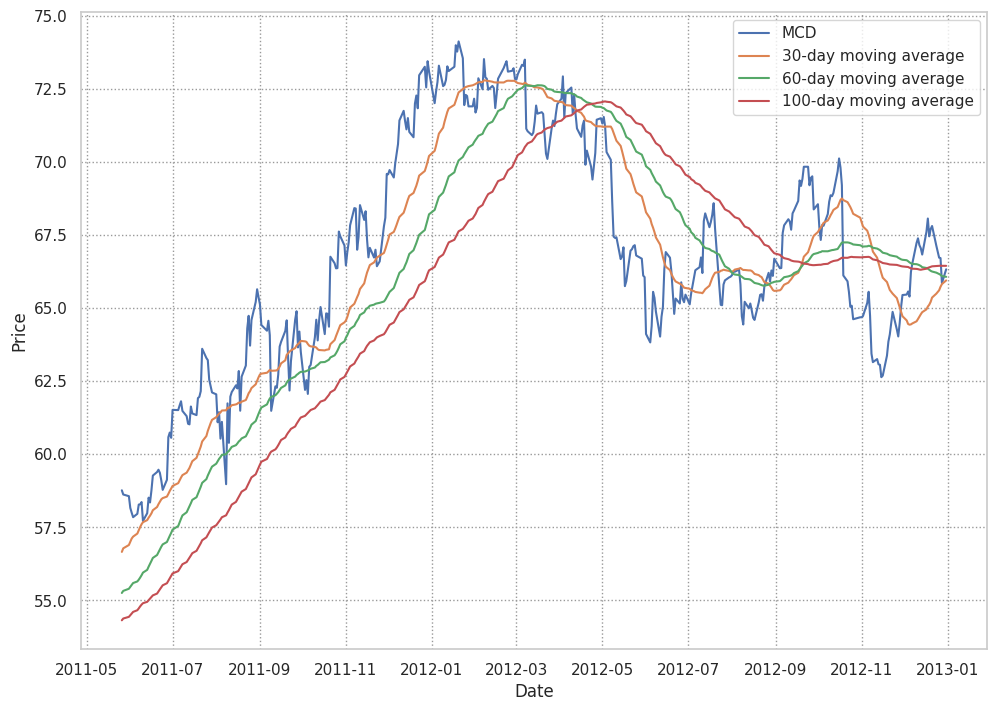

In [33]:
start = "2011-01-01"
end = "2013-01-01"

pricing = yf.download("MCD", start, end)
pricing = pricing["Adj Close"]

# compute rolling averages for various window lengths
mu_30d = pricing.rolling(window=30).mean()
mu_60d = pricing.rolling(window=60).mean()
mu_100d = pricing.rolling(window=100).mean()

# plot asset pricing data with rolling means from the 100th day, when all the means become available
sb.lineplot(pricing[100:], label="MCD")
sb.lineplot(mu_30d[100:], label="30-day moving average")
sb.lineplot(mu_60d[100:], label="60-day moving average")
sb.lineplot(mu_100d[100:], label="100-day moving average").set(xlabel="Date", ylabel="Price");

If the length is picked based on which one performs best, for that time period, the model will be overfit. Here's a trading algorithm which bets on the price reverting to the rolling mean (for more details, check out [this](./quantopian_lectures/15QLS_Multiple-Linear-Regression.ipynb) lecture). Using the performance of this algorithm to rank window lengths, and find the best one, will lead us to overfitting; when considering a different timeframe, the window length will be far from optimal.

In [34]:
# trade using a simple mean-reversion strategy
def trade(stock, length):

    # if window length is 0, algorithm doesn't make sense, so exit
    if length == 0:
        return 0

    # compute rolling mean and rolling standard deviation
    rolling_window = stock.rolling(window=length)
    mu = rolling_window.mean()
    std = rolling_window.std()

    # Compute the z-scores for each day using the historical data up to that day
    zscores = (stock - mu)/std

    # simulate trading
    # start with no money and no positions
    money = 0
    count = 0
    for i in range(len(stock)):
        # sell short if the z-score is > 1
        if zscores[i] > 1:
            money += stock[i]
            count -= 1
        # buy long if the z-score is < 1
        elif zscores[i] < -1:
            money -= stock[i]
            count += 1
        # clear positions if the z-score between -.5 and .5
        elif abs(zscores[i]) < 0.5:
            money += count*stock[i]
            count = 0
    return money

In [35]:
# find the window length 0-254 that gives the highest returns using this strategy
length_scores = [trade(pricing, l) for l in range(255)]
best_length = np.argmax(length_scores)
print("Best window length:", best_length)

Best window length: 11


In [36]:
# get pricing for a different timeframe
start2 = "2013-01-01"
end2 = "2015-01-01"

pricing2 = yf.download("MCD", start2, end2)
pricing2 = pricing2["Adj Close"]

# find the returns during this period with our "best fit" window
length_scores2 = [trade(pricing2, l) for l in range(255)]
print(best_length,"day window:", length_scores2[best_length])

# find the best window length of this dataset, and the returns
best_length2 = np.argmax(length_scores2)
print(best_length2,"day window:", length_scores2[best_length2])

[*********************100%***********************]  1 of 1 completed
11 day window: 18.195884704589844
141 day window: 320.4587631225586


Clearly, fitting to sample data does not always yield the best results. Here are the length scores from the two different timeframes:

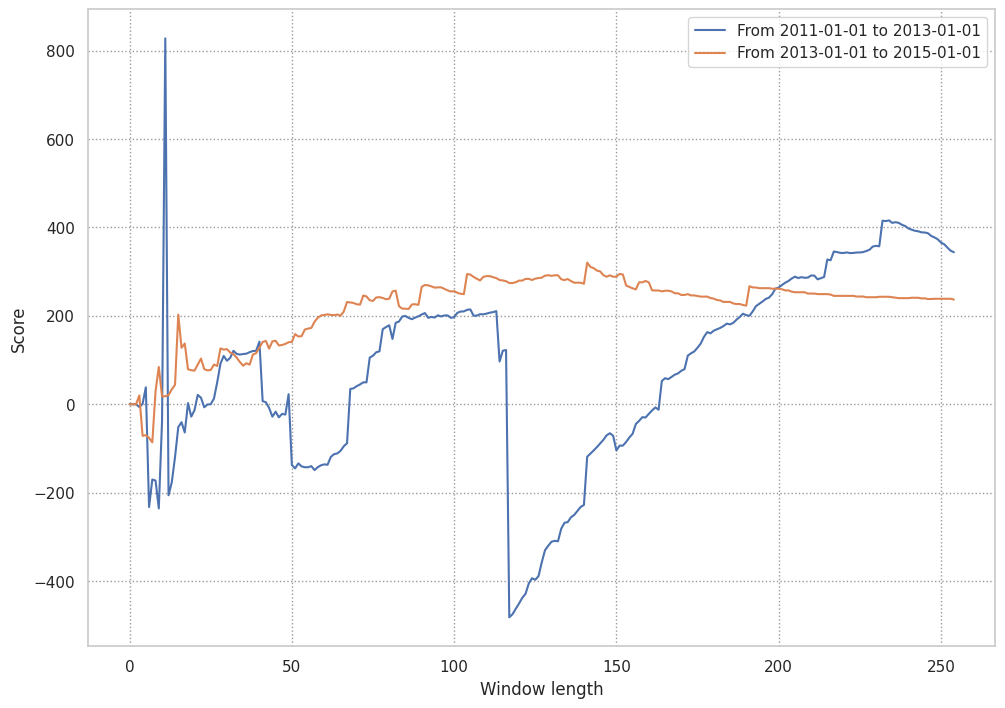

In [37]:
sb.lineplot(length_scores, label=f"From {start} to {end}")
sb.lineplot(length_scores2, label=f"From {start2} to {end2}").set(xlabel="Window length", ylabel="Score");

To avoid overfitting, economic reasoning or the nature of the algorithm can be used to pick window lengths. Kalman filters (covered in [this](./quantopian_lectures/48QLS_Kalman-Filters.ipynb) lecture) do not require a length.

## Avoiding Overfitting

This can be done by taking large samples, choosing reasonable and simple models, and not cherry-picking parameters that fit the data; problem is, running two backtests is already overfitting.

### Out of Sample (OOS) Testing

To make sure the model isn't overfit, test on out-of-sample data, and reach conclusions there. Simply put, unseen data (by the model) needs to be gathered in order to test it. If data can't be gathered at will, then the original dataset should be split into two chunks; reserving a portion of it for OOS.

#### Common Mistake: Abusing Out of Sample Data

If a model is constructed on in-sample data, then tested on out-of-sample data, and it is concluded that it does not work, a new hypothesis should be put to the test. But repeating the same process, on the same data, over and over until a model works, is still overfitting. This is because the model is essentially being trained on the out-of-sample data, so when it's put to the test on **true** OOS, it will most likely fail.

### Cross Validation

This is the process of splitting the data into $n$ parts, then estimating optimal parameters for $n-1$ parts  combined, and testing on the final part. By doing this $n$ times, one for each part held out, the stability and predictability of the parameters can be established on data that is not from the original set.

## Information Criterion

These are rigorous statistical tests that will check whether the amount of complexity in the model worth the extra predictive power. These tests favour simpler models, and will indicate if there is added complexity without much return. The most common method is [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion).